In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, NullFormatter
import time
from tqdm import tqdm
from pathlib import Path
import os

from numba import jit, njit, objmode

### Create and work with binary classification dataset

In [2]:
class BinaryDataset:
    '''
    Class for working with random binary classification data.
    
    Args:
        N - number of synapses in a NN
        alpha - number of learned patterns per synapse
        K - number of units in a NN
        distribution - distribution to draw samples from
        
    Constructed values:
        mu = alpha*N - number of patterns
        
    '''
    def __init__(self, N, alpha, K, distribution='uniform', seed=23):
        self.N = N
        self.alpha = alpha
        self.K = K
        self.mu = int(N * alpha)
        self.distribution = distribution
        self.seed = seed
        np.random.seed(seed)
        
        self.create_samples()
        
    def create_samples(self):
        if self.distribution == 'uniform':
            self.xi = 2*np.random.randint(0, 2, size=(self.mu,self.N)) - 1
            self.sigma = 2*np.random.randint(0, 2, size=(self.mu,1)) - 1
            self.xi = self.xi * self.sigma
            self.sigma *= self.sigma
        else:
            pass    

In [3]:
N = 105
alpha = 0.2
K = 1

dataset = BinaryDataset(N, alpha, K)
print(dataset.xi)
print(dataset.sigma[:,0])

[[-1  1  1 ...  1 -1 -1]
 [-1  1  1 ... -1 -1  1]
 [-1  1 -1 ... -1  1 -1]
 ...
 [ 1  1  1 ... -1 -1  1]
 [-1 -1  1 ... -1  1 -1]
 [ 1  1 -1 ... -1  1 -1]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Binary NNs for one-layer and committe machine case

In [3]:
class BinaryUnit:
    '''
    Binary unit as a part of binary NN.
    
    Args:
        N_unit - number of synapses in a unit
        seed - random number seed
    '''
    def __init__(self, N_unit, seed=23):
        self.N_unit = N_unit
        self.seed = seed
        
        self.init_weights()
    
    def init_weights(self):
        np.random.seed(self.seed)
        self.W = 2*np.random.randint(0, 2, size=(self.N_unit)) - 1
        
    def forward(self, xi):
        return np.sign(np.dot(self.W, xi))

    
class BinaryNN:
    '''
    Binary NN consisting of K binary units.
    
    Args:
        N - number of synapses in the whole network
        K - number of binary units
        seed - random number seed (int for uniform layer initialization, list for non-uniform)
        
    Constructed values:
        N_unit - number of synapses in a single unit
    '''
    def __init__(self, N, K, seed=23):
        self.N = N
        self.K = K
        self.seed = seed
        
        self.N_unit = N//K
        
        if type(seed) is int:
            self.units = [BinaryUnit(self.N_unit, seed=seed) for i in range(K)]
        elif type(seed) is list:
            self.units = [BinaryUnit(self.N_unit, seed=seed[i]) for i in range(K)]
        
    def forward(self, xi):
        outputs = [self.units[i].forward(xi[i*self.N_unit:(i+1)*self.N_unit]) for i in range(self.K)]
        return np.sign(np.sum(outputs))
    

class BinaryNNEnsemble:
    def __init__(self, N, K, y, seed=23):
        self.N = N
        self.K = K
        self.y = y
        self.seed = seed
        
        if K == 1:
            self.models = [BinaryUnit(N, seed=seed) for i in range(y)]
        else:
            self.models = [BinaryNN(N, K, seed=seed) for i in range(y)]

@njit
def create_binaryNN_ensemble(N, K, y, seed=23):
    np.random.seed(seed)
    W = 2*np.random.randint(0, 2, size=N) - 1
    W_ensemble = np.zeros((y,N), dtype=np.float64)
    for i in range(y):
        W_ensemble[i] = W
    return W_ensemble

In [4]:
N = 11
K = 1
y = 3
seed = 5

models = create_binaryNN_ensemble(N, K, y, seed)
print(models.shape)

(3, 11)


### Simulated Annealing

In [4]:
# @njit
# def energy_1(xi_arr, W):
#     delta_out = xi_arr @ W
#     energy = (-delta_out > 0.) * (-delta_out + 1) // 2
#     return int(np.sum(energy))

def energy_K(xi_arr, Ws):
    K = len(Ws)
    N_unit = len(Ws[0])
    energy = 0
    for i in range(xi_arr.shape[0]):
        xi = xi_arr[i]
        deltas = np.array([np.dot(xi[k*N_unit:(k+1)*N_unit], Ws[k]) for k in range(K)])
        idx_delta = deltas < 0
        delta_out = np.sum(np.sign(deltas))
        c = 0.5*(-delta_out + 1)
        s = np.sort(-0.5*(deltas[idx_delta] - 1))
        energy += np.heaviside(-delta_out) * np.sum(s[:c])
    return energy

@njit
def calc_energy_ensemble(models, xi_arr, K=1):
    delta_out = xi_arr @ models.T * (-1.)
    energies = (delta_out > 0.) * (delta_out + 1.) * 0.5
    return np.sum(energies, axis=0)

@njit
def delta_energy_mu_1(mu, W_i, xi_i, p_minus, p_plus, delta_out):
    if np.any(p_plus == mu):
        if xi_i != W_i:
            return 0
        return 1
    elif np.any(p_minus == mu):
        if xi_i != W_i:
            if delta_out == -1:
                return 0
            else:
                return -1
        return 1
    else:
        return 0


def delta_energy_mu(mu, k, i, Wik, p_minus, p_plus):
    pass

# @njit
# def delta_energy_1(xi_arr, W, i):
#     mu_idx = np.arange(xi_arr.shape[0])
#     delta_out = xi_arr @ W
#     p_plus = mu_idx[delta_out == 1]
#     p_minus = mu_idx[delta_out < 0]
#     dE = 0
#     for mu in range(len(mu_idx)):
#         dE += delta_energy_mu_1(mu, W[i], xi_arr[mu][i], p_minus, p_plus, delta_out[mu])
#     return dE

@njit
def delta_energy_1(xi_arr, W, i):
    delta_out = xi_arr @ W
    
    # p_plus = (delta_out == 1)
    p_minus = (delta_out < 0)
    xi_fl = (xi_arr[:,i] == W[i])
    # delta_fl = (delta_out != -1)
    
    dE = np.sum(np.logical_or(delta_out == 1, p_minus) * xi_fl)
    dE -= np.sum(p_minus * np.logical_not(xi_fl) * (delta_out != -1))
    return dE

@njit
def calc_kj(idx, gamma, Wjs):
    s = np.sum(Wjs[:idx]) + np.sum(Wjs[idx+1:])
    k = 0.5 * np.log(np.cosh(gamma + gamma*s)/np.cosh(-gamma + gamma*s))
    return k

@njit
def simulated_annealing_step(beta, gamma, models, xi_arr, idx_y, idx_i):
    accept = 0
    # compute probability of the move and make the move
    dE = delta_energy_1(xi_arr, models[idx_y], idx_i)
    
    if gamma > 0:
        kj = calc_kj(idx_y, gamma, models[:,idx_i])
        Wj = models[idx_y, idx_i]
        p = min([1, np.exp(-beta*dE-2*kj*Wj)])
    else:
        p = min([1, np.exp(-beta*dE)])
    if np.random.random() < p:
        models[idx_y, idx_i] *= -1
        accept = 1
    return models, accept

@njit
def simulated_annealing(models, xi_arr, beta0, dbeta, gamma0, dgamma, n_steps=100000,
                        step_beta=1000):
    y, N = models.shape[0], xi_arr.shape[1]
    beta = beta0
    gamma = gamma0
    step_beta = step_beta * len(models)
    n_accepted = 0
    n_non_improving = 0
    early_stop = False
    i = 0
    energies_last = calc_energy_ensemble(models, xi_arr)
    while (n_non_improving <= 1000*y*N) and (i < n_steps):
        # pick a random move
        idx_y = np.random.randint(0, y)
        idx_i = np.random.randint(0, N)
        models, accept = simulated_annealing_step(beta, gamma, models, xi_arr, idx_y, idx_i)
        if accept:
            energies = calc_energy_ensemble(models, xi_arr)
            n_accepted += accept
            
            if np.any(energies == 0):
                idx = np.arange(y)[energies == 0]
                return models, idx[0], i, n_accepted
            
            if np.sum(energies_last) <= np.sum(energies):
                n_non_improving += 1
            else:
                energies_last = energies.copy()
                n_non_improving = 0
            
            if (n_accepted+1) % step_beta == 0: 
                beta *= (1 + dbeta)
                if gamma != 0:
                    gamma *= (1 + dgamma)
                n_accepted += 1
        else:
            n_non_improving += 1
        i += 1
    return models, None, i, n_accepted

def choose_average_model(models):
    W = np.sign(np.sum(models, axis=0))
    return W

In [10]:
K = 1
N = K * 201
alpha = 0.2
y = 3
seed = 122
np.random.seed(seed)
n_steps = 200000
step_beta = 1000

beta0 = 0.5
dbeta = 0.2
gamma0 = 0.1
dgamma = 0.1

dataset = BinaryDataset(N, alpha, K, seed=seed)
xi_arr = dataset.xi.astype(np.float64)
# models = create_binaryNN_ensemble(N, K, y, seed)

n_avg = 40
t = 0
for i in range(n_avg):
    models = create_binaryNN_ensemble(N, K, y, seed)
    t0 = time.time()
    models_fitted, idx, i = simulated_annealing(models, xi_arr, beta0, dbeta, gamma0, dgamma, 
                                                n_steps=n_steps, step_beta=step_beta)
    t1 = time.time() - t0
    # print(f'Time old: {t1}')
    t += t1
print(t / n_avg)

0.008229863643646241


In [11]:
# Best model
print(f'Best model is {idx}')
output = xi_arr @ models_fitted[idx]
print(f'# of mismatches for best model: {np.sum(np.sign(output) < 0)}')

# average model
average_model = choose_average_model(models_fitted)
output = xi_arr @ average_model 
print(f'# of mismatches for average model: {np.sum(np.sign(output) < 0)}')

Best model is 0
# of mismatches for best model: 0
# of mismatches for average model: 3


### Series of simulation results for 1-layer networks

1. For fixed $\alpha$ produce data for SA with and without interaction for different N.
2. For each N in the previous point, make several runs for different $(\beta_0, \beta_{step}, \gamma, \gamma_{step})$.
3. Сheck other reasonable values of $\alpha$.

In [5]:
@njit
def run_diferent_T_params(N, K, y, seed, xi_arr,
                          beta0_arr, dbeta_arr, gamma0_arr, dgamma_arr,
                          n_steps=200000, step_beta=1000, mode='no interaction'):
    i_min = 1e10
    n_accepted_min = 1e10
    W0 = create_binaryNN_ensemble(N, K, y, seed)

    if mode == 'no interaction':
        beta0_min, dbeta_min = beta0_arr[0], dbeta_arr[0]
        for idx_beta0, beta0 in enumerate(beta0_arr):
            for idx_dbeta, dbeta in enumerate(dbeta_arr):
                models = W0.copy()

                models_fitted, idx, i, n_accepted = simulated_annealing(models, xi_arr, beta0, dbeta, 0, 0, 
                                                            n_steps=n_steps, step_beta=step_beta)

                if i < i_min:
                    beta0_min, dbeta_min = beta0, dbeta
                    i_min = i
                if n_accepted < n_accepted_min:
                    n_accepted_min = n_accepted
        min_params = [beta0_min, dbeta_min]
    else:
        beta0_min, dbeta_min = beta0_arr[0], dbeta_arr[0]
        gamma0_min, dgamma_min = gamma0_arr[0], dgamma_arr[0]
        for idx_beta0, beta0 in enumerate(beta0_arr):
            for idx_dbeta, dbeta in enumerate(dbeta_arr):
                for idx_gamma0, gamma0 in enumerate(gamma0_arr):
                    for idx_dgamma, dgamma in enumerate(dgamma_arr):
                        models = W0.copy()

                        models_fitted, idx, i, n_accepted = simulated_annealing(models, xi_arr,
                                                                    beta0, dbeta, gamma0, dgamma, 
                                                                    n_steps=n_steps, step_beta=step_beta)

                        if i < i_min:
                            beta0_min, dbeta_min = beta0, dbeta
                            gamma0_min, dgamma_min = gamma0, dgamma
                            i_min = i
                        if n_accepted < n_accepted_min:
                            n_accepted_min = n_accepted
        min_params = [beta0_min, dbeta_min, gamma0_min, dgamma_min]

    return i_min, min_params, n_accepted_min

def gather_stats_for_different_samples(N, K, y, seed, alpha, 
                                       n_samples, seeds_arr, beta_gamma_arrs,
                                       n_steps=100000, step_beta=1000, mode='no interaction',
                                       save_path=''):
    accepted_min_arr, iter_min_arr = [np.zeros(n_samples) for i in range(2)]
    for i in tqdm(range(n_samples), desc='dataset_samples'):
        dataset = BinaryDataset(N, alpha, K, seed=seeds_arr[i])
        xi_arr = dataset.xi.astype(np.float64)
        
        n_iter_min, min_params, n_accepted_min = run_diferent_T_params(N, K, y, seed, xi_arr,
                                                        beta_gamma_arrs[0], beta_gamma_arrs[1],
                                                        beta_gamma_arrs[2], beta_gamma_arrs[3],
                                                        n_steps=n_steps, step_beta=step_beta,
                                                        mode=mode)
        # iter_min_arr[i] = np.min(n_iter_arr)
        iter_min_arr[i] = n_iter_min
        accepted_min_arr[i] = n_accepted_min
        # print(min_params)
    
    if save_path != None:
        folder = 'no_interaction' if mode == 'no interaction' else 'interaction'
        folder += f"/alpha_{alpha}_K_{K}_y_{y}/"
        save_path = os.path.join(save_path, folder)
        Path(save_path).mkdir(parents=True, exist_ok=True)
        
        np.save(save_path + f"N_{N}_accepted.npy", accepted_min_arr)
        np.save(save_path + f"N_{N}_iter.npy", iter_min_arr)
    
    return iter_min_arr

#### $\alpha = 0.2, y = 3$

In [21]:
K = 1
alpha = 0.2
y = 3
seed = 521
step_beta = 1000
n_units = [101, 201, 401, 801, 1601]
mode = 'interaction'

beta0_arr = np.array([0.5, 1, 2, 5, 10])
dbeta_arr = np.array([0.2, 0.5, 1, 2, 5])
gamma0_arr = np.array([0.1, 0.5, 1])
dgamma_arr = np.array([0.01, 0.05, 0.1, 0.2])

beta_gamma_arrs = (beta0_arr, dbeta_arr, gamma0_arr, dgamma_arr)

n_samples = 10
dataset_seeds = [43, 5768, 1111, 986, 23, 13, 90, 43434, 999, 45389]

In [22]:
N = K * n_units[0]
n_steps = 1000 * N

modes = ['interaction', 'no interaction']
for mode in modes:
    iter_min_arr = gather_stats_for_different_samples(N, K, y, seed, alpha,
                                                     n_samples, dataset_seeds,
                                                     beta_gamma_arrs, n_steps,
                                                     step_beta, mode)

dataset_samples: 100%|██████████| 10/10 [00:00<00:00, 15.14it/s]


In [25]:
N = K * n_units[1]
n_steps = 1000 * N

modes = ['interaction', 'no interaction']
for mode in modes:
    iter_min_arr = gather_stats_for_different_samples(N, K, y, seed, alpha,
                                                     n_samples, dataset_seeds,
                                                     beta_gamma_arrs, n_steps,
                                                     step_beta, mode)

dataset_samples: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


In [31]:
N = K * n_units[2]
n_steps = 1000 * N

modes = ['interaction', 'no interaction']
for mode in modes:
    iter_min_arr = gather_stats_for_different_samples(N, K, y, seed, alpha,
                                                     n_samples, dataset_seeds,
                                                     beta_gamma_arrs, n_steps,
                                                     step_beta, mode)

dataset_samples: 100%|██████████| 10/10 [04:53<00:00, 29.36s/it]


In [28]:
N = K * n_units[3]
n_steps = 1000 * N

modes = ['interaction', 'no interaction']
for mode in modes:
    iter_min_arr = gather_stats_for_different_samples(N, K, y, seed, alpha,
                                                     n_samples, dataset_seeds,
                                                     beta_gamma_arrs, n_steps,
                                                     step_beta, mode)

dataset_samples: 100%|██████████| 10/10 [29:54<00:00, 179.49s/it]


In [32]:
idx = 2

iter_no_inter = np.load(f'no_interaction/alpha_{alpha}_K_1_/N_{n_units[idx]}_iter.npy')
iter_inter = np.load(f'interaction/alpha_{alpha}_K_1_/N_{n_units[idx]}_iter.npy')

accepted_no_inter = np.load(f'no_interaction/alpha_{alpha}_K_1_/N_{n_units[idx]}_accepted.npy')
accepted_inter = np.load(f'interaction/alpha_{alpha}_K_1_/N_{n_units[idx]}_accepted.npy')

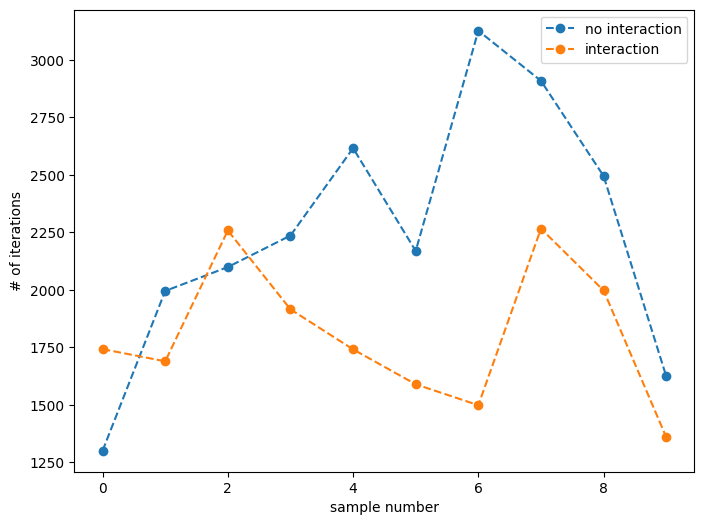

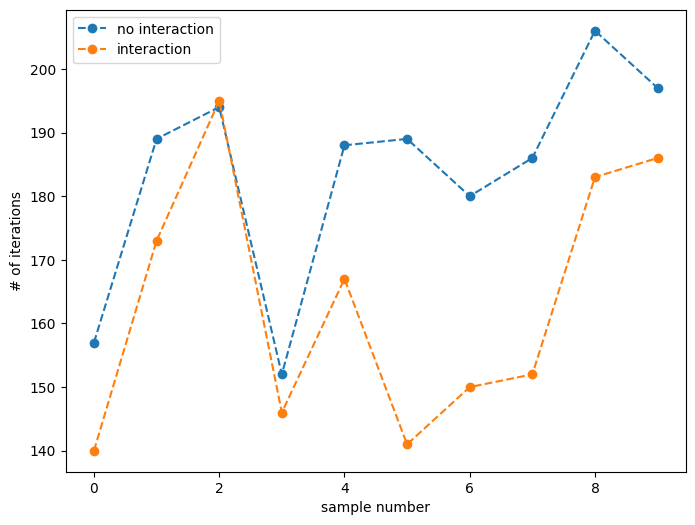

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(np.arange(n_samples), iter_no_inter, '.--', ms=12, label='no interaction')
plt.plot(np.arange(n_samples), iter_inter, '.--', ms=12, label='interaction')
plt.xlabel('sample number')
plt.ylabel('# of iterations')
plt.legend(loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(np.arange(n_samples), accepted_no_inter, '.--', ms=12, label='no interaction')
plt.plot(np.arange(n_samples), accepted_inter, '.--', ms=12, label='interaction')
plt.xlabel('sample number')
plt.ylabel('# of iterations')
plt.legend(loc='best')
plt.show()

#### $\alpha = 0.3, y = 3$

In [35]:
K = 1
alpha = 0.3
y = 3
seed = 521
step_beta = 1000
n_units = [101, 201, 401, 801, 1601]
mode = 'interaction'

beta0_arr = np.array([0.5, 1, 2, 5, 10])
dbeta_arr = np.array([0.2, 0.5, 1, 2, 5])
gamma0_arr = np.array([0.1, 0.5, 1])
dgamma_arr = np.array([0.01, 0.05, 0.1, 0.2])

beta_gamma_arrs = (beta0_arr, dbeta_arr, gamma0_arr, dgamma_arr)

n_samples = 10
dataset_seeds = [43, 5768, 1111, 986, 23, 13, 90, 43434, 999, 45389]

In [36]:
N = K * n_units[0]
n_steps = 1000 * N

modes = ['interaction', 'no interaction']
for mode in modes:
    iter_min_arr = gather_stats_for_different_samples(N, K, y, seed, alpha,
                                                     n_samples, dataset_seeds,
                                                     beta_gamma_arrs, n_steps,
                                                     step_beta, mode)

dataset_samples: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


In [42]:
N = K * n_units[1]
n_steps = 1000 * N

modes = ['interaction', 'no interaction']
for mode in modes:
    iter_min_arr = gather_stats_for_different_samples(N, K, y, seed, alpha,
                                                     n_samples, dataset_seeds,
                                                     beta_gamma_arrs, n_steps,
                                                     step_beta, mode)

dataset_samples: 100%|██████████| 10/10 [03:22<00:00, 20.28s/it]


In [43]:
N = K * n_units[2]
n_steps = 1000 * N

modes = ['interaction', 'no interaction']
for mode in modes:
    iter_min_arr = gather_stats_for_different_samples(N, K, y, seed, alpha,
                                                     n_samples, dataset_seeds,
                                                     beta_gamma_arrs, n_steps,
                                                     step_beta, mode)

dataset_samples: 100%|██████████| 10/10 [13:51<00:00, 83.18s/it]


In [39]:
N = K * n_units[3]
n_steps = 1000 * N

modes = ['interaction', 'no interaction']
for mode in modes:
    iter_min_arr = gather_stats_for_different_samples(N, K, y, seed, alpha,
                                                     n_samples, dataset_seeds,
                                                     beta_gamma_arrs, n_steps,
                                                     step_beta, mode)

dataset_samples: 100%|██████████| 10/10 [1:05:17<00:00, 391.79s/it]


In [44]:
idx = 2

iter_no_inter = np.load(f'no_interaction/alpha_{alpha}_K_1_/N_{n_units[idx]}_iter.npy')
iter_inter = np.load(f'interaction/alpha_{alpha}_K_1_/N_{n_units[idx]}_iter.npy')

accepted_no_inter = np.load(f'no_interaction/alpha_{alpha}_K_1_/N_{n_units[idx]}_accepted.npy')
accepted_inter = np.load(f'interaction/alpha_{alpha}_K_1_/N_{n_units[idx]}_accepted.npy')

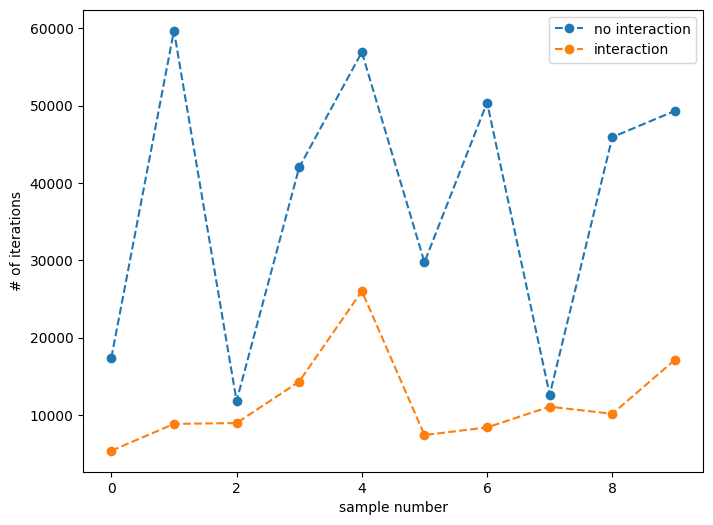

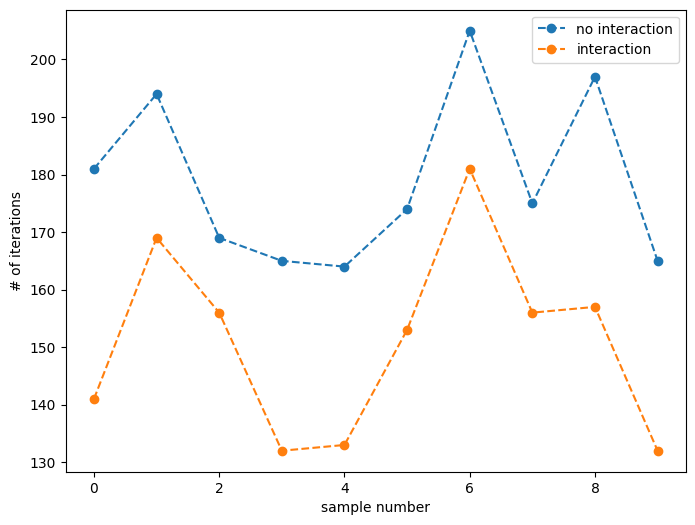

In [45]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(np.arange(n_samples), iter_no_inter, '.--', ms=12, label='no interaction')
plt.plot(np.arange(n_samples), iter_inter, '.--', ms=12, label='interaction')
plt.xlabel('sample number')
plt.ylabel('# of iterations')
plt.legend(loc='best')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(np.arange(n_samples), accepted_no_inter, '.--', ms=12, label='no interaction')
plt.plot(np.arange(n_samples), accepted_inter, '.--', ms=12, label='interaction')
plt.xlabel('sample number')
plt.ylabel('# of iterations')
plt.legend(loc='best')
plt.show()

#### $\alpha=0.3, y=5$

In [6]:
K = 1
alpha = 0.3
y = 5
seed = 521
step_beta = 1000
n_units = [101, 201, 401, 801, 1601]
mode = 'interaction'

beta0_arr = np.array([0.5, 1, 2, 5, 10])
dbeta_arr = np.array([0.2, 0.5, 1, 2, 5])
gamma0_arr = np.array([0.1, 0.5, 1])
dgamma_arr = np.array([0.01, 0.05, 0.1, 0.2])

beta_gamma_arrs = (beta0_arr, dbeta_arr, gamma0_arr, dgamma_arr)

n_samples = 5
dataset_seeds = [43, 5768, 1111, 986, 23]#, 13, 90, 43434, 999, 45389]

In [7]:
N = K * n_units[0]
n_steps = 1000 * N

modes = ['interaction', 'no interaction']
for mode in modes:
    iter_min_arr = gather_stats_for_different_samples(N, K, y, seed, alpha,
                                                     n_samples, dataset_seeds,
                                                     beta_gamma_arrs, n_steps,
                                                     step_beta, mode)

dataset_samples: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


In [8]:
N = K * n_units[1]
n_steps = 1000 * N

modes = ['interaction', 'no interaction']
for mode in modes:
    iter_min_arr = gather_stats_for_different_samples(N, K, y, seed, alpha,
                                                     n_samples, dataset_seeds,
                                                     beta_gamma_arrs, n_steps,
                                                     step_beta, mode)

dataset_samples: 100%|██████████| 5/5 [03:41<00:00, 44.40s/it]


In [10]:
N = K * n_units[2]
n_steps = 1000 * N

modes = ['interaction', 'no interaction']
for mode in modes:
    iter_min_arr = gather_stats_for_different_samples(N, K, y, seed, alpha,
                                                     n_samples, dataset_seeds,
                                                     beta_gamma_arrs, n_steps,
                                                     step_beta, mode)

dataset_samples: 100%|██████████| 5/5 [09:17<00:00, 111.47s/it]


In [9]:
N = K * n_units[3]
n_steps = 1000 * N

modes = ['interaction', 'no interaction']
for mode in modes:
    iter_min_arr = gather_stats_for_different_samples(N, K, y, seed, alpha,
                                                     n_samples, dataset_seeds,
                                                     beta_gamma_arrs, n_steps,
                                                     step_beta, mode)

dataset_samples: 100%|██████████| 5/5 [44:17<00:00, 531.56s/it]


#### Analyze obtained data

In [12]:
# Analyze the obtained data
N_arr = np.array([101, 201, 401, 801])
alpha = 0.2
y = 3
folder_no_int = f'no_interaction/alpha_{alpha}_K_1_y_{y}/' 
folder_int = f'interaction/alpha_{alpha}_K_1_y_{y}/'

i_dict = {'no_interaction': {}, 'interaction': {}}
i_mean_dict = {'no_interaction': [], 'interaction': []}

acc_dict = {'no_interaction': {}, 'interaction': {}}
acc_mean_dict = {'no_interaction': [], 'interaction': []}

for mode, folder in zip(['no_interaction', 'interaction'], [folder_no_int, folder_int]):
    for N in N_arr:
        i_arr = np.load(folder + f'N_{N}_iter.npy')
        accept_arr = np.load(folder + f'N_{N}_accepted.npy')
        i_dict[mode][N] = i_arr.copy()
        acc_dict[mode][N] = accept_arr.copy()

        i_mean = np.mean(i_arr)
        accept_mean = np.mean(accept_arr)

        i_mean_dict[mode].append(i_mean)
        acc_mean_dict[mode].append(accept_mean)

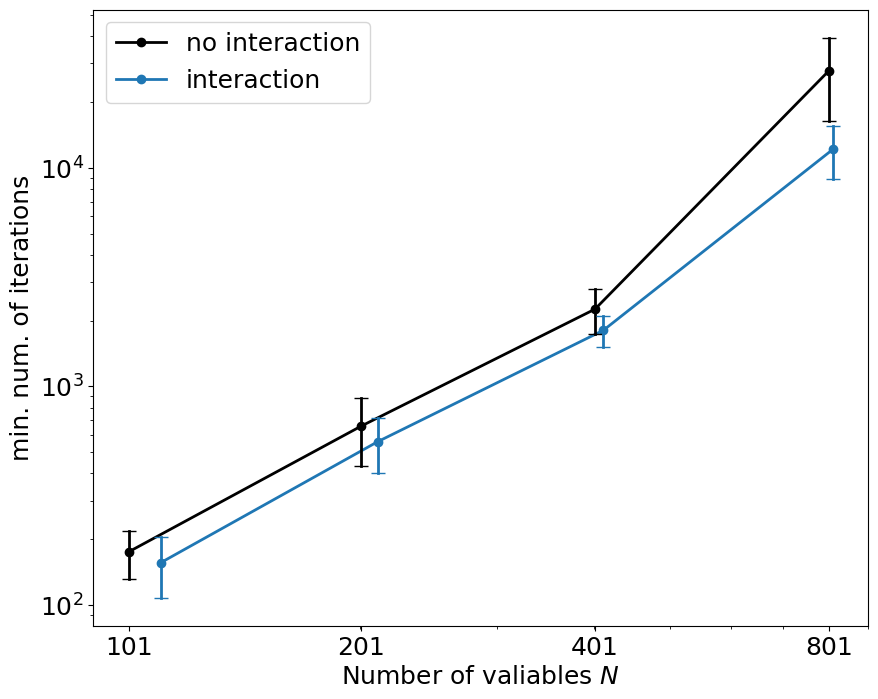

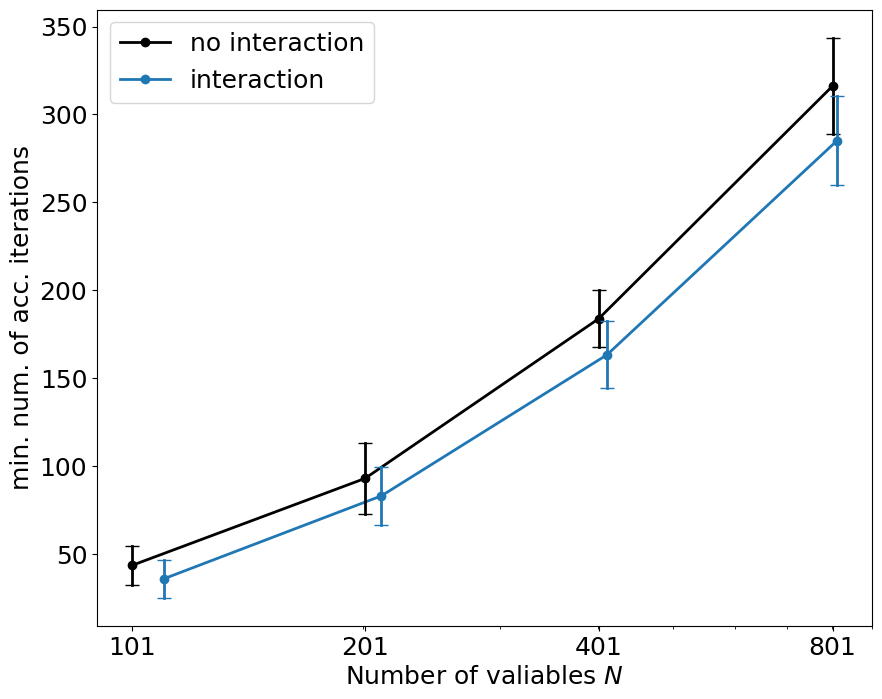

In [14]:
d = 10

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(N_arr, i_mean_dict['no_interaction'], '.-', linewidth=2, ms=12,
         color='black', label='no interaction')
plt.plot(N_arr+d, i_mean_dict['interaction'], '.-',linewidth=2, ms=12, label='interaction')
for i,N in enumerate(N_arr):
    for mode, color, delta in zip(['no_interaction', 'interaction'], ['black', 'tab:blue'], [0,d]):
        mu = i_mean_dict[mode][i]
        std = np.std(i_dict[mode][N])
        plt.plot([N+delta, N+delta], [mu-std, mu+std], '-_', color=color, linewidth=2, ms=10)
plt.yticks(fontsize=18)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([101, 201, 401, 801], fontsize=18)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
plt.xticks(fontsize=18)
plt.xlabel('Number of valiables $N$', fontsize=18)
plt.ylabel('min. num. of iterations', fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(N_arr, acc_mean_dict['no_interaction'], '.-', linewidth=2, ms=12,
         color='black', label='no interaction')
plt.plot(N_arr+d, acc_mean_dict['interaction'], '.-',linewidth=2, ms=12, label='interaction')
for i,N in enumerate(N_arr):
    for mode, color, delta in zip(['no_interaction', 'interaction'], ['black', 'tab:blue'], [0,d]):
        mu = acc_mean_dict[mode][i]
        std = np.std(acc_dict[mode][N])
        plt.plot([N+delta, N+delta], [mu-std, mu+std], '-_', color=color, linewidth=2, ms=10)
plt.yticks(fontsize=18)
# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([101, 201, 401, 801], fontsize=18)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
plt.xticks(fontsize=18)
plt.xlabel('Number of valiables $N$', fontsize=18)
plt.ylabel('min. num. of acc. iterations', fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

In [23]:
# Analyze the obtained data
N_arr = np.array([101, 201, 401, 801])
alpha = 0.3
y = [3,5]
folder_no_int = f'no_interaction/alpha_{alpha}_K_1_y_{y[0]}/' 
folder_int = f'interaction/alpha_{alpha}_K_1_y_{y[0]}/'
folder_int_5 = f'interaction/alpha_{alpha}_K_1_y_{y[1]}/'

i_dict = {'no_interaction': {}, 'interaction': {}, 'interaction_5': {}}
i_mean_dict = {'no_interaction': [], 'interaction': [], 'interaction_5': []}

acc_dict = {'no_interaction': {}, 'interaction': {}, 'interaction_5': {}}
acc_mean_dict = {'no_interaction': [], 'interaction': [], 'interaction_5': []}

for mode, folder in zip(['no_interaction', 'interaction', 'interaction_5'],
                        [folder_no_int, folder_int, folder_int_5]):
    for N in N_arr:
        i_arr = np.load(folder + f'N_{N}_iter.npy')
        accept_arr = np.load(folder + f'N_{N}_accepted.npy')
        i_dict[mode][N] = i_arr.copy()
        acc_dict[mode][N] = accept_arr.copy()

        i_mean = np.mean(i_arr)
        accept_mean = np.mean(accept_arr)

        i_mean_dict[mode].append(i_mean)
        acc_mean_dict[mode].append(accept_mean)

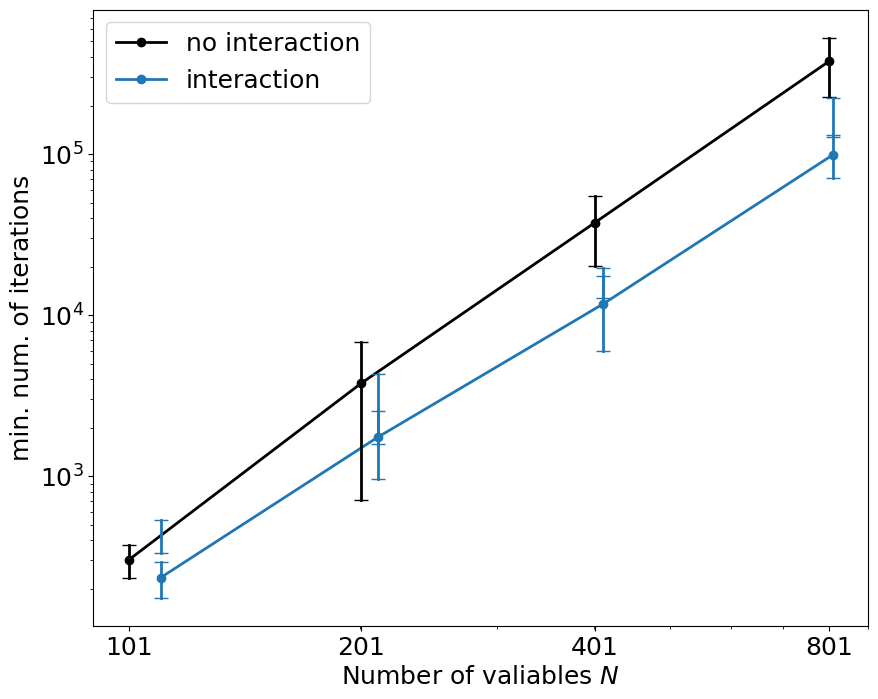

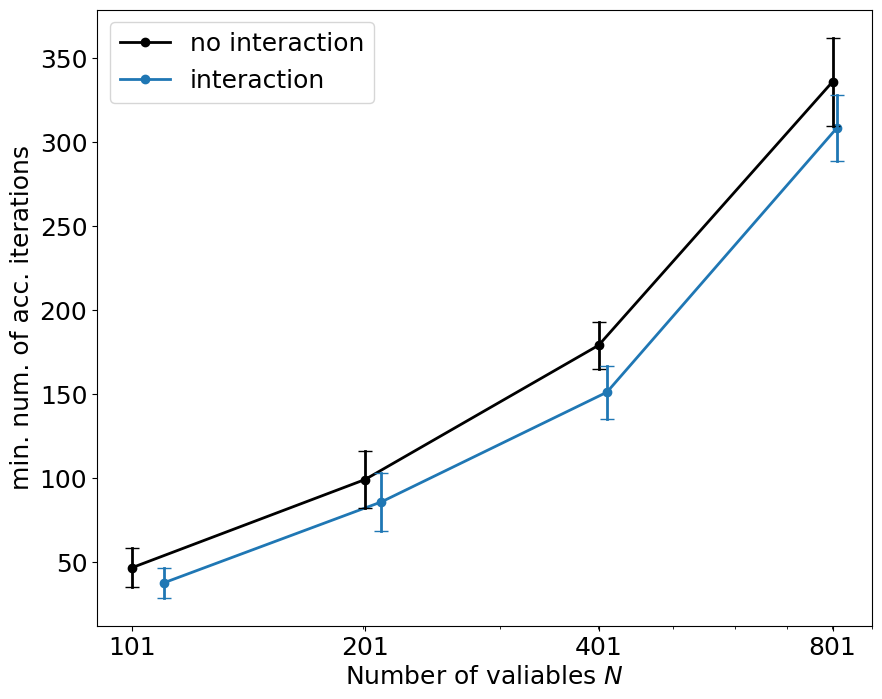

In [25]:
d = 10

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(N_arr, i_mean_dict['no_interaction'], '.-', linewidth=2, ms=12,
         color='black', label='no interaction')
plt.plot(N_arr+d, i_mean_dict['interaction'], '.-',linewidth=2, ms=12, label='interaction')
# plt.plot(N_arr+d, i_mean_dict['interaction_5'], '.--',linewidth=2, ms=12, label='interaction, $y=5$')
for i,N in enumerate(N_arr):
    for mode, color, delta in zip(['no_interaction', 'interaction', 'interaction_5'],
                                  ['black', 'tab:blue', 'tab:blue'], [0,d,d]):
        mu = i_mean_dict[mode][i]
        std = np.std(i_dict[mode][N])
        plt.plot([N+delta, N+delta], [mu-std, mu+std], '-_', color=color, linewidth=2, ms=10)
plt.yticks(fontsize=18)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([101, 201, 401, 801], fontsize=18)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
plt.xticks(fontsize=18)
plt.xlabel('Number of valiables $N$', fontsize=18)
plt.ylabel('min. num. of iterations', fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(N_arr, acc_mean_dict['no_interaction'], '.-', linewidth=2, ms=12,
         color='black', label='no interaction')
plt.plot(N_arr+d, acc_mean_dict['interaction'], '.-',linewidth=2, ms=12, label='interaction')
# plt.plot(N_arr+d, acc_mean_dict['interaction_5'], '.-',linewidth=2, ms=12, label='interaction, $y=5$')
for i,N in enumerate(N_arr):
    for mode, color, delta in zip(['no_interaction', 'interaction'], ['black', 'tab:blue'], [0,d]):
        mu = acc_mean_dict[mode][i]
        std = np.std(acc_dict[mode][N])
        plt.plot([N+delta, N+delta], [mu-std, mu+std], '-_', color=color, linewidth=2, ms=10)
plt.yticks(fontsize=18)
# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([101, 201, 401, 801], fontsize=18)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
plt.xticks(fontsize=18)
plt.xlabel('Number of valiables $N$', fontsize=18)
plt.ylabel('min. num. of acc. iterations', fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

In [20]:
# Analyze the obtained data
N_arr = np.array([101, 201, 401, 801])
alpha = 0.3
y = 5
folder_no_int = f'no_interaction/alpha_{alpha}_K_1_y_{y}/' 
folder_int = f'interaction/alpha_{alpha}_K_1_y_{y}/'

i_dict = {'no_interaction': {}, 'interaction': {}}
i_mean_dict = {'no_interaction': [], 'interaction': []}

acc_dict = {'no_interaction': {}, 'interaction': {}}
acc_mean_dict = {'no_interaction': [], 'interaction': []}

for mode, folder in zip(['no_interaction', 'interaction'], [folder_no_int, folder_int]):
    for N in N_arr:
        i_arr = np.load(folder + f'N_{N}_iter.npy')
        accept_arr = np.load(folder + f'N_{N}_accepted.npy')
        i_dict[mode][N] = i_arr.copy()
        acc_dict[mode][N] = accept_arr.copy()

        i_mean = np.mean(i_arr)
        accept_mean = np.mean(accept_arr)

        i_mean_dict[mode].append(i_mean)
        acc_mean_dict[mode].append(accept_mean)

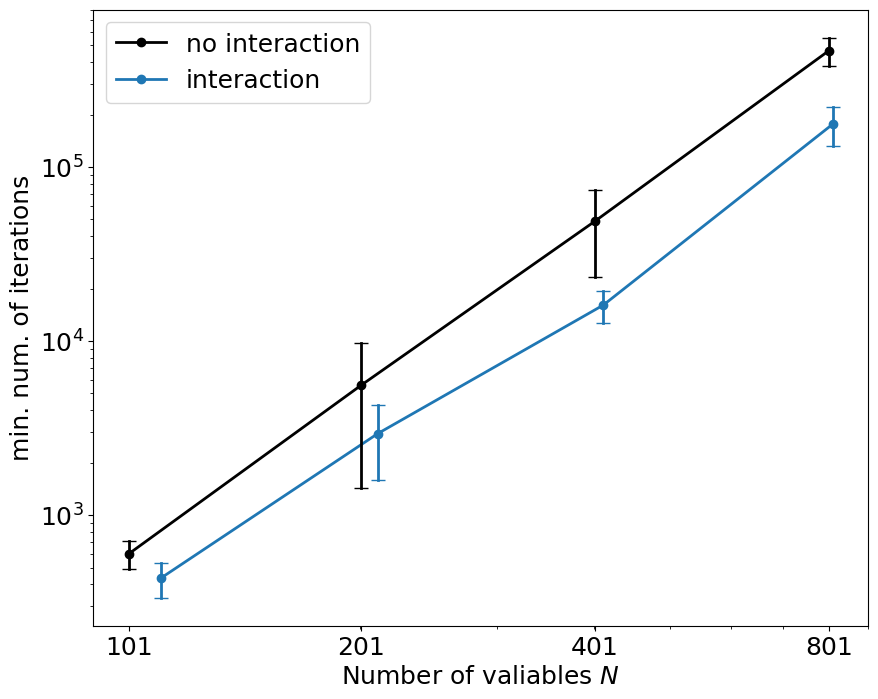

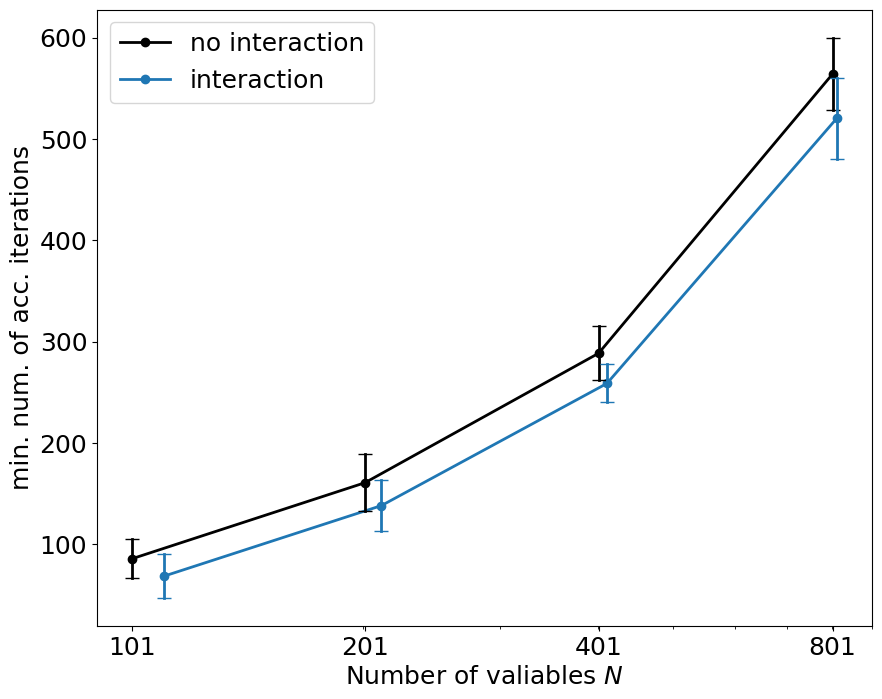

In [21]:
d = 10

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(N_arr, i_mean_dict['no_interaction'], '.-', linewidth=2, ms=12,
         color='black', label='no interaction')
plt.plot(N_arr+d, i_mean_dict['interaction'], '.-',linewidth=2, ms=12, label='interaction')
for i,N in enumerate(N_arr):
    for mode, color, delta in zip(['no_interaction', 'interaction'], ['black', 'tab:blue'], [0,d]):
        mu = i_mean_dict[mode][i]
        std = np.std(i_dict[mode][N])
        plt.plot([N+delta, N+delta], [mu-std, mu+std], '-_', color=color, linewidth=2, ms=10)
plt.yticks(fontsize=18)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([101, 201, 401, 801], fontsize=18)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
plt.xticks(fontsize=18)
plt.xlabel('Number of valiables $N$', fontsize=18)
plt.ylabel('min. num. of iterations', fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.plot(N_arr, acc_mean_dict['no_interaction'], '.-', linewidth=2, ms=12,
         color='black', label='no interaction')
plt.plot(N_arr+d, acc_mean_dict['interaction'], '.-',linewidth=2, ms=12, label='interaction')
for i,N in enumerate(N_arr):
    for mode, color, delta in zip(['no_interaction', 'interaction'], ['black', 'tab:blue'], [0,d]):
        mu = acc_mean_dict[mode][i]
        std = np.std(acc_dict[mode][N])
        plt.plot([N+delta, N+delta], [mu-std, mu+std], '-_', color=color, linewidth=2, ms=10)
plt.yticks(fontsize=18)
# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks([101, 201, 401, 801], fontsize=18)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(NullFormatter())
plt.xticks(fontsize=18)
plt.xlabel('Number of valiables $N$', fontsize=18)
plt.ylabel('min. num. of acc. iterations', fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()